# DC2 Run1.2 object catalog footprint (Spark)
<br> Kernel: **desc-pyspark**
<br>Owner: **S Plaszczynski** (https://github.com/LSSTDESC/DC2-production/issues/299)
<br>Last Verified to Run: **2018-11-18**
    
The goal of this notebook is to have a QA look a the dc2-data-access produced object_catalog (currently on Run1.2p)
It also illustrates how simple and efficient Spark is.


## load the full Run1.2 catalog from single parquet file

In [53]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()
print("spark session started")

spark session started


In [54]:
object_catalog="/global/cscratch1/sd/plaszczy/Run1.2p/object_catalog/full_catalog.parquet"
df_all=spark.read.parquet(object_catalog)
df_all.printSchema()

root
 |-- magerr_g: double (nullable = true)
 |-- I_flag_g: boolean (nullable = true)
 |-- tract: long (nullable = true)
 |-- IxyPSF_y: double (nullable = true)
 |-- I_flag_y: boolean (nullable = true)
 |-- Ixx_i: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- magerr_u: double (nullable = true)
 |-- mag_z_cModel: double (nullable = true)
 |-- mag_u: double (nullable = true)
 |-- snr_g_cModel: double (nullable = true)
 |-- Ixx: double (nullable = true)
 |-- mag_u_cModel: double (nullable = true)
 |-- magerr_y: double (nullable = true)
 |-- magerr_r_cModel: double (nullable = true)
 |-- IxyPSF_r: double (nullable = true)
 |-- psFlux_y: double (nullable = true)
 |-- magerr_y_cModel: double (nullable = true)
 |-- mag_g_cModel: double (nullable = true)
 |-- Iyy_i: double (nullable = true)
 |-- I_flag_z: boolean (nullable = true)
 |-- snr_u_cModel: double (nullable = true)
 |-- Ixy_z: double (nullable = true)
 |-- psFluxErr_r: double (nullable = true)
 |-- mag_i_cModel: dou

In [55]:
#select relevant columns (we alos add the filter flags)
cols="tract,patch,ra,dec"
for f in ['u','g','r','i','z','y']:
    s=",psFlux_flag_{}".format(f)
    cols+=s
print(cols)

df=df_all.select(cols.split(','))
N=df.cache().count()
print("#galaxies={} millions".format(N/1e6))
Nf=df.filter((df['psFlux_flag_u']==True) | \
            (df['psFlux_flag_g']==True) | \
            (df['psFlux_flag_r']==True) | \
            (df['psFlux_flag_i']==True) | \
            (df['psFlux_flag_z']==True) | \
            (df['psFlux_flag_y']==True)).count()
print("#galaxies with f={} millions".format(Nf/1e6))

tract,patch,ra,dec,psFlux_flag_u,psFlux_flag_g,psFlux_flag_r,psFlux_flag_i,psFlux_flag_z,psFlux_flag_y
#galaxies=27.083536 millions
#galaxies with f=1.793273 millions


## Look at tracts and patches

In [56]:
df.select("tract").distinct().count() #check that all the tracts are present

20

According to https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/dm_butler_skymap.ipynb This is OK. how many patches per tract?

In [57]:
df.groupBy(["tract","patch"]).count().groupBy("tract").count().\
withColumnRenamed("count","#patches").sort("tract").show()  #groupBy twice, rename and sort

+-----+--------+
|tract|#patches|
+-----+--------+
| 4429|      42|
| 4430|      56|
| 4431|      56|
| 4432|      56|
| 4433|       7|
| 4636|      16|
| 4637|      64|
| 4638|      64|
| 4639|      64|
| 4640|      48|
| 4848|      48|
| 4849|      64|
| 4850|      64|
| 4851|      64|
| 4852|      16|
| 5062|      17|
| 5063|      56|
| 5064|      56|
| 5065|      56|
| 5066|      35|
+-----+--------+



## (ra,dec) footprint

In [10]:
#are there some Nans?
import numpy as np
df.filter(df['ra'].contains(np.nan)).count()

0

No so lets do some basic statistics

In [11]:
df.describe(['ra','dec']).show()

+-------+------------------+-------------------+
|summary|                ra|                dec|
+-------+------------------+-------------------+
|  count|          27083536|           27083536|
|   mean| 55.07338013097766| -29.79419390003542|
| stddev|1.9014363884446157|  1.643124412278626|
|    min| 51.74916962374651| -32.58858724482577|
|    max| 58.36818361208815|-26.947017635210035|
+-------+------------------+-------------------+



We will project galaxies in a Healpix map. For that we define a pandas User Defined Function to call healpy ang2pix function

In [142]:
import pandas as pd
import numpy as np
import healpy as hp
from pyspark.sql.functions import pandas_udf, PandasUDFType

nside=2048
#create the ang2pix user-defined-function. 
#we use pandas_udf because they are more efficient
@pandas_udf('int', PandasUDFType.SCALAR)
def Ang2Pix(ra,dec):
    return pd.Series(hp.ang2pix(nside,np.radians(90-dec),np.radians(ra)))

In [143]:
#add a column of healpix indices
df=df.withColumn("ipix",Ang2Pix("ra","dec"))
#groupby indices and count the number of elements in each group
df_map=df.groupBy("ipix").count()
#statistics per pixel
df_map.describe(['count']).show() 

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|             38202|
|   mean| 708.9559708915764|
| stddev|215.22373289498606|
|    min|                 1|
|    max|              1658|
+-------+------------------+



In [144]:
#back to python world
map_p=df_map.toPandas()

In [145]:
#now data is reduced create the healpy map
counts = np.zeros(hp.nside2npix(nside))
counts[map_p['ipix'].values]=map_p['count'].values
counts[counts==0]=hp.UNSEEN

<Figure size 432x288 with 0 Axes>

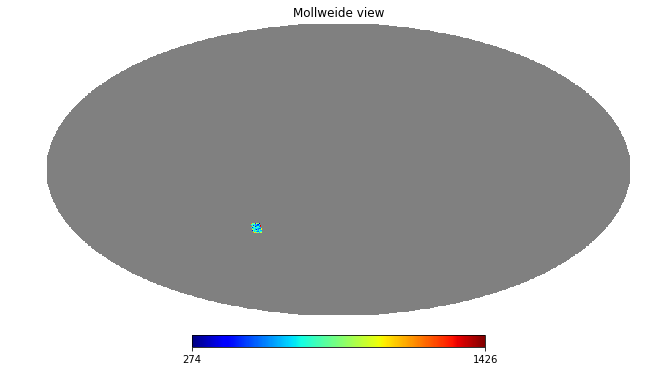

In [146]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('jet') #color-blind people should comment this line

hp.mollview(counts)

from the previous mean ra/dec and count statistics we can zoom on the center and perform a gnomonic projection

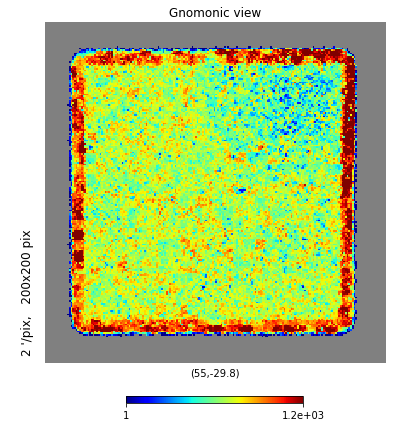

In [149]:
hp.gnomview(counts,rot=[55,-29.8],reso=2,max=1200)

Tracts outline: 
for each tract build the map and flag pixels with some neighbours unseen

In [150]:
#list of tracts
tract_num=df.select("tract").distinct().collect()
ipix=np.arange(hp.nside2npix(nside))
pixborder=[]
for p in range(len(tract_num)):
    num=tract_num[p][0]
    print(num,end=',')
    #create a map just for this tract
    df_map=df.filter(df.tract==num).groupBy("ipix").count()
    #create the healpix map
    tract_p=df_map.toPandas()
    tract_map = np.zeros(hp.nside2npix(nside))
    tract_map[tract_p['ipix'].values]=tract_p['count'].values
    tract_map[tract_map==0]=hp.UNSEEN
    # for lit pixels compute the neighbours
    ipix1=tract_p['ipix'].values
    theta,phi=hp.pix2ang(nside,ipix1)
    neighbours=hp.get_all_neighbours(nside,theta,phi,0).transpose()
    # border if at least one neighbours is UNSEEN
    mask=[(hp.UNSEEN in tract_map[neighbours[pixel]]) for pixel in range(len(ipix1))]
    pixborder+=list(ipix1[mask])

4848,4636,4639,5065,5064,4637,4432,5063,4640,4433,4429,5066,4430,4638,4431,4851,4849,4852,5062,4850,

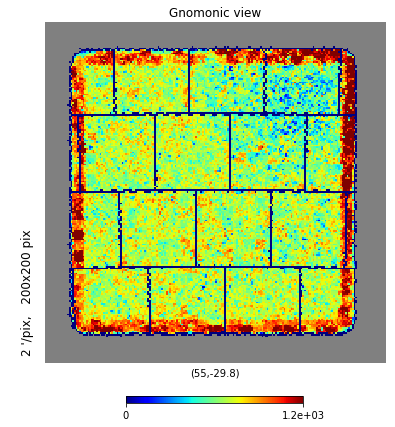

In [152]:
count_t=counts
count_t[pixborder]=-1
hp.gnomview(count_t,rot=[55,-29.8],reso=2,min=0,max=1200)

## Hot spots

In [136]:
t=df.filter(df.tract==4640).groupBy("patch").count()

In [137]:
t.show(5)

+-----+-----+
|patch|count|
+-----+-----+
|  4,3|37800|
|  3,1|68666|
|  2,6|  140|
|  2,7|  203|
|  3,2|47241|
+-----+-----+
only showing top 5 rows



we go back to the standard python world and create a dictionary of occupancy per patch 

In [138]:
occ=dict(t.toPandas().values)

then fill a 8x8 matrix from these to see which patches are missing

In [139]:
import numpy as np
mat=np.zeros([8,8],'int')
for k in occ.keys():
    i=int(k[0])
    j=int(k[2])
    mat[i,j]=occ[k]

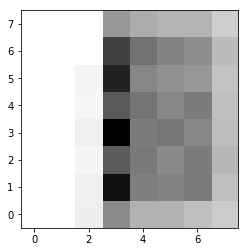

In [141]:
plt.imshow(mat.transpose(),origin='lower',cmap='binary');

Loks like the hot-spots corresponds to **patches=3,1/3,3/4,5**